In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

files = ['coretech.txt.zip', 'background.txt.zip', 'whycolab.txt.zip', 'backgroundAccept.txt.zip']

filename = files[0]


In [2]:
f = open('test.txt')
f.read()
# vocabulary = tf.compat.as_str(f).split()
print(f)
# print('Data size', len(f))


FileNotFoundError: [Errno 2] No such file or directory: 'test.txt'

In [9]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 88026


In [10]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 3000
randomWords = []

# finding bad and good words
posWords = ['collaborate', 'Blockchain', 'curious', ]
negWords = []

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    word = word.strip(',')
    word = word.strip('.')
    word = word.strip('?')
    word = word.strip('!')
    word = word.strip('"')

    if word in dictionary:
      index = dictionary[word]
    else:
      randomWords.append(word)
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  print(len(reversed_dictionary))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:50])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

print(randomWords)

3000
Most common words (+UNK) [['UNK', 9404], ('the', 3689), ('and', 3281), ('to', 3123), ('of', 2476), ('a', 1764), ('in', 1712), ('I', 1651), ('that', 1142), ('is', 1029), ('for', 813), ('with', 736), ('can', 690), ('be', 638), ('as', 576), ('are', 541), ('we', 511), ('it', 509), ('on', 485), ('more', 457), ('have', 449), ('our', 438), ('about', 419), ('an', 417), ('how', 405), ('am', 396), ('my', 384), ('will', 356), ('by', 349), ('this', 344), ('technology', 332), ('these', 330), ('new', 299), ('technologies', 293), ('reality', 285), ('The', 280), ('or', 280), ('people', 271), ('VR', 269), ('me', 264), ('potential', 263), ('excited', 262), ('virtual', 258), ('their', 255), ('AI', 254), ('from', 254), ('at', 238), ('but', 228), ('has', 227), ('could', 226)]
Sample data [0, 0, 730, 7, 123, 3, 301, 1259, 6, 1937] ['UNK', 'UNK', '--', 'I', 'want', 'to', 'build', 'schools', 'in', 'factories']
['Current', 'Idea', 'drop', 'Link', 'constellations', "that'll", 'teachers', 'needy', 'structur

In [11]:

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


0 UNK -> 730 --
0 UNK -> 0 UNK
730 -- -> 0 UNK
730 -- -> 7 I
7 I -> 730 --
7 I -> 123 want
123 want -> 7 I
123 want -> 3 to


In [12]:

# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()


In [13]:

# Step 5: Begin training.
num_steps = 10001 # was 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  197.417175293
Nearest to with: rising, today., w/, current, us,, ,, improved, storytelling,,
Nearest to very: emotional, first-hand, question,, problems, challenged, step, growing, training,,
Nearest to we: industry,, transformative, convinced, greatly, sensor, balance, tend, building,
Nearest to these: explored, contracts., outcomes, twitter, Data, applicability, world.", companies,
Nearest to so: science,, -, training,, believe, me, exposure, fields, skills.,
Nearest to virtual: Through, whenever, history,, ubiquitous, flow, groundbreaking, patients,, purchased,
Nearest to by: favorite, lives, From, effect, individual, stand, analyze, frontier,
Nearest to help: human, continually, Once, through, clear, movement, mind., interactive,
Nearest to design: experience., struggle, simplify, coming, activity, blockchain,, projects., break,
Nearest to future: "Blockchains, For, limited, player, team., computers., creators, year,
Nearest to such: one,, pop

['UNK', 'the', 'and', 'to', 'of', 'a', 'in', 'I', 'that', 'is', 'for', 'with', 'can', 'be', 'as', 'are', 'we', 'it', 'on', 'more', 'have', 'our', 'about', 'an', 'how', 'am', 'my', 'will', 'by', 'this', 'technology', 'these', 'new', 'technologies', 'reality', 'The', 'or', 'people', 'VR', 'me', 'potential', 'excited', 'virtual', 'their', 'AI', 'from', 'at', 'but', 'has', 'could', 'into', 'like', 'think', 'because', 'IoT', 'internet', 'things', 'also', 'way', 'they', 'world', 'so', 'was', 'which', 'what', 'design', 'not', 'interested', 'make', 'see', 'experience', 'all', 'would', 'human', 'believe', 'create', 'help', 'most', "I'm", 'future', 'augmented', 'through', '"', 'been', 'us', 'use', 'artificial', 'intelligence', 'data', 'many', 'such', 'very', 'AR', 'work', 'its', 'when', 'As', 'one', 'better', 'learning', 'It', 'In', 'where', 'change', 'This', 'other', 'really', 'much', 'emerging', 'able', 'information', 'exciting', 'do', 'working', 'only', 'using', 'become', 'just', 'than', 'tim

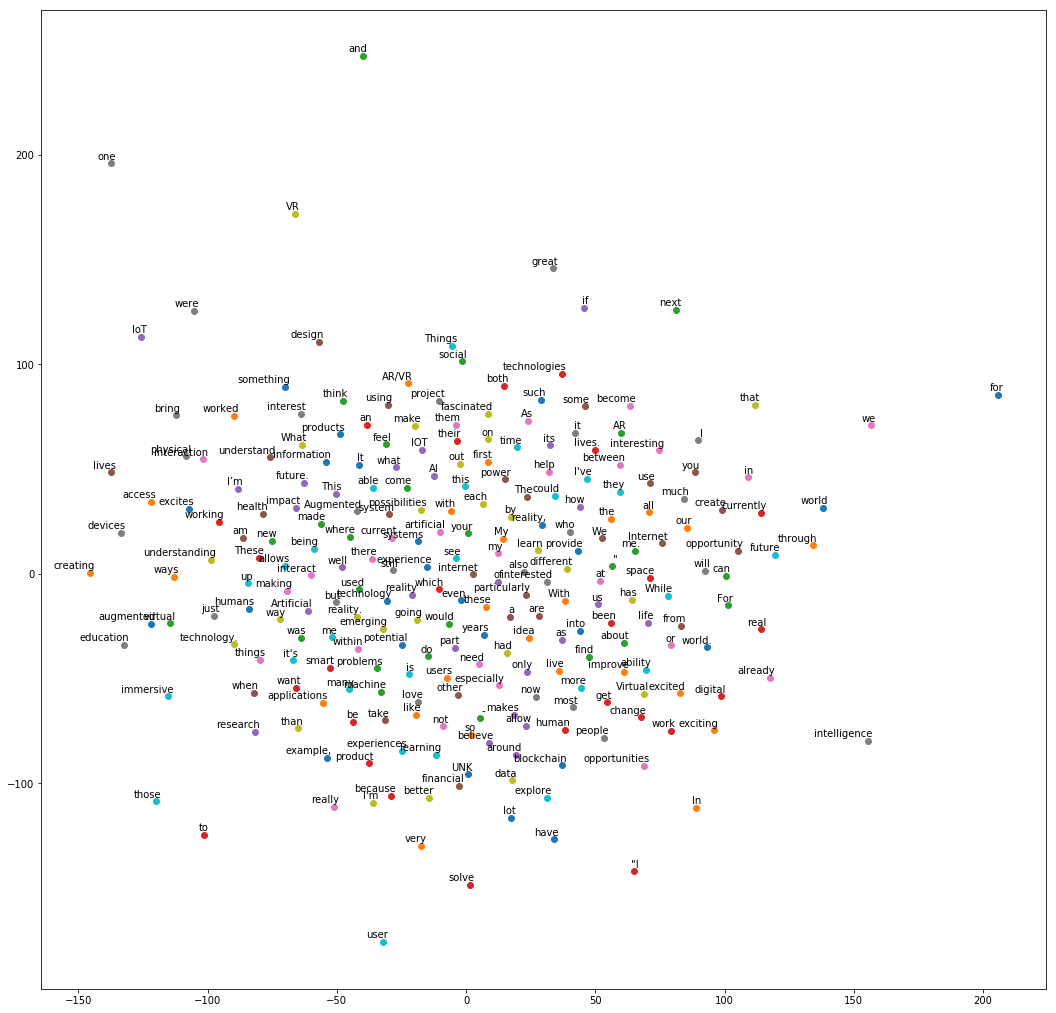

In [14]:
# # Step 6: Visualize the embeddings.


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  # import matplotlib
  # matplotlib.use('TkAgg')
  import matplotlib.pyplot as plt
  %matplotlib inline

  tsne = TSNE(perplexity=30, n_components=2
              , init='pca', n_iter=5000)
  plot_only = 250
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  print(labels)

  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')